### Single variable integration

In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

In [2]:
np.random.seed(32)

### Function Data Generation


In [3]:
def Line(samples):

    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-5, 5)
        y = x

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Exp(samples):
    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-5, 5)
        y = np.exp(x)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Inverse(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        xm = np.arange(-1, 0, 1/10)
        xp = np.arange(0.1, 1.1, 1/10)
        xarr = xm+xp
        x = np.random.choice(xarr)
        y = 1 / (10*x)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Square(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        x = np.random.uniform(-2, 2)
        y = x**2

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)


#### Data Plotting

In [16]:
def plot_data(x, y, problem, fig = None, ax = None):
    
    if fig == None:
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
                               
    samples = len(x)
    xlin = np.linspace(-5, 5)

    for _ in range(samples):
        ax.scatter(x, y, alpha=0.5, color = 'c', s= 7)

    if problem == 'line':
        ax.plot(xlin, xlin, color = 'r')

    if problem == 'exp':
        ax.plot(xlin, np.exp(xlin-1), color = 'r')

    if problem == 'inverse':
        ax.plot(xlin, 1 / (10*xlin), color = 'r')
    
    if problem == 'square':
        ax.plot(xlin, xlin**2, color = 'r')

    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.grid()

### VQC Model

In [5]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(params, xdata, num_qubits, num_layers):
    
    idx = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            qml.RY(params[idx], wires = i)
            qml.RZ(params[idx+1]*xdata, wires = i, id= 'Data Upload')
            qml.RZ(params[idx+2], wires = i)
            qml.RY(params[idx+3], wires = i)
            qml.RZ(params[idx+4], wires = i)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])

    
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    for i in range(num_qubits):
        qml.RY(params[-1-i], wires = i)
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
        obs @= qml.PauliZ(i+1)

    return qml.expval(obs)
# ------------------------------------------------- #
'''
num_qubits = 4
num_layers = 1

params = np.random.uniform(size = num_qubits*(5*num_layers + num_layers + 1), requires_grad = True)
xdata = [1]

print(qml.draw(VQC_Model)(params, xdata[0], num_qubits, num_layers))
print(VQC_Model(params, xdata[0], num_qubits, num_layers))
'''

'\nnum_qubits = 4\nnum_layers = 1\n\nparams = np.random.uniform(size = num_qubits*(5*num_layers + num_layers + 1), requires_grad = True)\nxdata = [1]\n\nprint(qml.draw(VQC_Model)(params, xdata[0], num_qubits, num_layers))\nprint(VQC_Model(params, xdata[0], num_qubits, num_layers))\n'

### Cost function

In [6]:
def cost_function(params, xdata, num_qubits, num_layers, ydata):
    loss = 0.0

    for i in range(len(xdata)):
        pred = 10 * VQC_Model(params, xdata[i], num_qubits, num_layers)
        loss += ((pred - ydata[i]))**2

    return loss / len(xdata)

### Circuit Executing

In [7]:
def model_running(params, xdata, num_qubits, num_layers):

    prediction = []

    for i in range(len(xdata)):
        pred = 10 * VQC_Model(params, xdata[i], num_qubits, num_layers)
        prediction.append(pred)

    return np.array(prediction)

### Utility

In [8]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [9]:
def iterate_minibatches(inputs, targets, batch_size):
    
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-----

In [19]:
### Preparing datas
train_data, train_target = Line(50)
test_data, test_target = Line(100)

# Ansatz Setting
num_qubits = 1
num_layers = 8

# Trainnig option settings
epochs = 250
lr = 0.003

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer

# Initializing random parameters for the circuit
params = np.random.uniform(size = 5*num_qubits*num_layers+num_qubits, requires_grad = True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(params, train_data, num_qubits, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(params, test_data, num_qubits, num_layers)
ratio_test, score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(params, test_data, num_qubits, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    params, _, _, _, _ = opt.step(cost_function, params, train_data, num_qubits, num_layers, train_target)

    pred_train = model_running(params, train_data, num_qubits, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(params, train_data, num_qubits, num_layers, train_target)

    pred_test = model_running(params, test_data, num_qubits, num_layers)
    ratio_test, score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 31.694649 | Train accuracy: 0.020000 | Test Accuracy: 0.050000
Epoch:  1 | Loss: 30.678298 | Train accuracy: 0.040000 | Test accuracy: 0.050000
Epoch:  2 | Loss: 29.295000 | Train accuracy: 0.060000 | Test accuracy: 0.050000
Epoch:  3 | Loss: 27.908486 | Train accuracy: 0.060000 | Test accuracy: 0.060000
Epoch:  4 | Loss: 26.509129 | Train accuracy: 0.060000 | Test accuracy: 0.040000
Epoch:  5 | Loss: 25.096861 | Train accuracy: 0.100000 | Test accuracy: 0.030000
Epoch:  6 | Loss: 23.679506 | Train accuracy: 0.080000 | Test accuracy: 0.030000
Epoch:  7 | Loss: 22.267585 | Train accuracy: 0.080000 | Test accuracy: 0.020000
Epoch:  8 | Loss: 20.871545 | Train accuracy: 0.120000 | Test accuracy: 0.040000
Epoch:  9 | Loss: 19.500467 | Train accuracy: 0.140000 | Test accuracy: 0.040000
Epoch: 10 | Loss: 18.161992 | Train accuracy: 0.120000 | Test accuracy: 0.050000
Epoch: 11 | Loss: 16.863442 | Train accuracy: 0.100000 | Test accuracy: 0.050000
Epoch: 12 | Loss: 15.612725 

----

### Checking Results

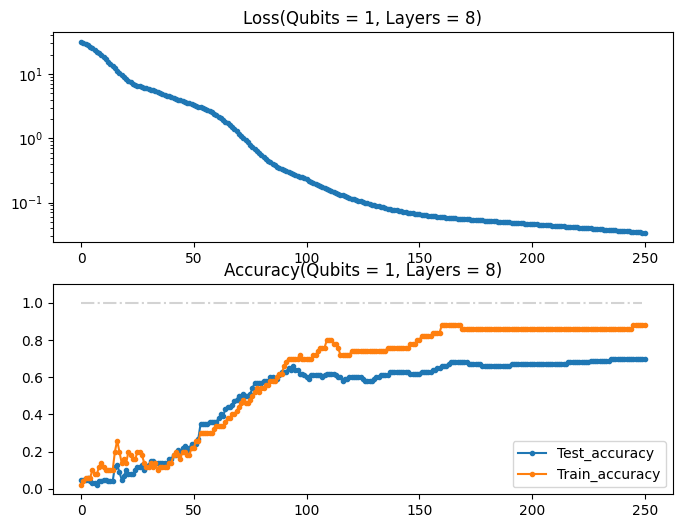

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
limit = [1]*epochs

axes[0].plot(loss_list,'.-')
axes[0].set_yscale('log')
axes[0].set_title(f"Loss(Qubits = {num_qubits}, Layers = {num_layers})")

axes[1].plot(limit, '-.', c = 'lightgray')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[1].legend()
axes[1].set_ylim(top = 1.1)
axes[1].set_title(f"Accuracy(Qubits = {num_qubits}, Layers = {num_layers})")

plt.show()

Cost: 0.033891 | Train accuracy 0.880000 | Test Accuracy : 0.700000
Learned weights
0: ──RY(1.02)──RZ(0.51,"Data Upload")──RZ(0.20)──RY(0.41)──RZ(0.35)──RY(0.74)

───RZ(0.37,"Data Upload")──RZ(-0.04)──RY(0.77)──RZ(0.73)──RY(0.42)──RZ(0.87,"Data Upload")──RZ(0.64)

───RY(0.82)──RZ(0.59)──RY(0.60)──RZ(0.93,"Data Upload")──RZ(0.48)──RY(0.70)──RZ(0.03)──RY(0.74)

───RZ(0.61,"Data Upload")──RZ(0.93)──RY(0.98)──RZ(1.00)──RY(1.05)──RZ(0.40,"Data Upload")──RZ(0.37)

───RY(0.23)──RZ(0.56)──RY(0.13)──RZ(0.27,"Data Upload")──RZ(0.51)──RY(0.63)──RZ(0.70)──RY(0.19)

───RZ(0.38,"Data Upload")──RZ(0.88)──RY(-0.06)──RZ(0.90)──RY(0.24)─┤  <Z>


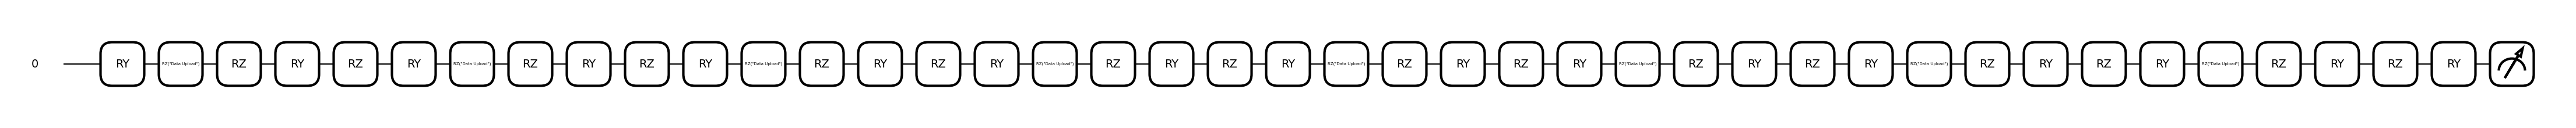

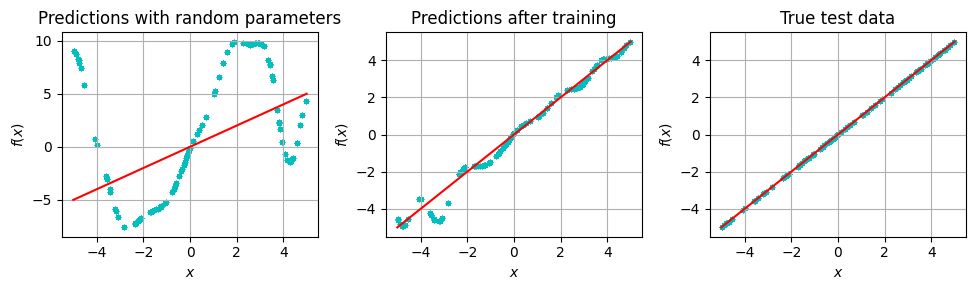

In [21]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
x = 1
print(qml.draw(VQC_Model)(params, x, num_qubits, num_layers))
fig, ax = qml.draw_mpl(VQC_Model)(params, x, num_qubits, num_layers)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot_data(x, y, problem, fig = None, ax = None)
plot_data(test_data, initial_predictions, 'line', fig, axes[0])
plot_data(test_data, pred_test, 'line' ,fig, axes[1])
plot_data(test_data, test_target, 'line' ,fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

-----

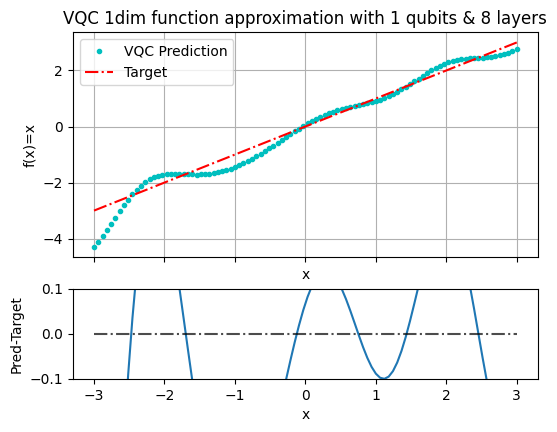

In [22]:
xlin = np.linspace(-3,3,100)
approxi = model_running(params, xlin, num_qubits, num_layers)


fig, axis = plt.subplots(
    2, 1, sharex=True, figsize=(6, 6 * 6 / 8), gridspec_kw={"height_ratios": [5, 2]}
)
axis[0].set_title(f"VQC 1dim function approximation with {num_qubits} qubits & {num_layers} layers")
axis[0].plot(xlin, approxi, 'c.',label = "VQC Prediction")
axis[0].plot(xlin, xlin, 'r-.' ,label = "Target")
axis[0].legend()
axis[0].grid(True)
axis[0].set_xlabel('x')
axis[0].set_ylabel('f(x)=x')


axis[1].plot(xlin, approxi-xlin, label = 'difference')
axis[1].hlines(0, -3, 3, color="black", alpha=0.7, ls="-.", lw=1.5)
axis[1].set_ylim(-0.1,0.1)
axis[1].set_ylabel("Pred-Target")
axis[1].set_xlabel('x')
axis[1].grid(False)


plt.show()